In [15]:
# pip install sentence-transformers lightgbm scikit-learn

In [16]:
# pip install protobuf==3.20.3

# 1단계: 라이브러리 설치 및 데이터 로드

In [32]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import matplotlib.pyplot as plt
import time
import platform
from matplotlib import font_manager, rc
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [ ]:
print("데이터 로드 중...")
df = pd.read_csv(r'C:\hanchon\data\processed\model_ready_dataset.csv')

# date 컬럼을 다시 datetime 객체로 변환
df['date'] = pd.to_datetime(df['date'])
print("데이터 로드 완료:", df.shape)


# 데이터 20% 샘플링(SBERT 시용)
# df = df.sample(frac=0.2, random_state=42).copy()
# print(f"데이터 샘플링 완료. Shape: {df.shape}")

데이터 로드 중...
데이터 로드 완료: (2398650, 27)


# 2단계: SBERT 피처 엔지니어링 (메뉴명 벡터화)

In [19]:
# print("\n--- 2. SBERT 인코딩 시작 ---")
# # 1. 사전 학습된 한국어 SBERT 모델 로드
# sbert_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

# # 2. 고유한 '메뉴명' 목록 추출
# unique_menus = df['메뉴명'].unique()
# print(f"고유 메뉴명 개수: {len(unique_menus)}")

# # 3. 고유 메뉴명을 SBERT 벡터로 변환 (인코딩)
# start_time = time.time()
# print("SBERT 인코딩 중... (몇 분 정도 소요될 수 있습니다)")
# menu_embeddings = sbert_model.encode(unique_menus)
# end_time = time.time()
# print(f"인코딩 완료. (소요 시간: {end_time - start_time:.2f}초)")

# # 4. '메뉴명'과 '벡터'를 짝지어주는 딕셔너리(map) 생성
# embedding_map = dict(zip(unique_menus, menu_embeddings))

# # 5. df['메뉴명']을 키로 벡터를 적용 -> sbert_features_list 변수에 저장
# print("SBERT 벡터를 데이터프레임에 적용 중...")
# sbert_features_list = df['메뉴명'].map(embedding_map)

# # 6. 벡터를 384개의 개별 컬럼으로 분리 (메모리 최적화)
# print("SBERT 벡터를 float32 데이터프레임으로 변환 중... (메모리 절약)")
# try:
#     sbert_df = pd.DataFrame(sbert_features_list.tolist(), index=df.index, dtype='float32')
#     sbert_df.columns = [f'sbert_{i}' for i in range(sbert_df.shape[1])]
    
#     # 7. 원본 데이터프레임에 SBERT 컬럼들 병합
#     df = pd.concat([df, sbert_df], axis=1)
    
#     # 8. (중요!) 메모리 확보를 위해 더 이상 필요 없는 변수 삭제
#     del sbert_features_list
#     del sbert_df
#     print("SBERT 인코딩 완료. Shape:", df.shape)
#     df.info()

# except MemoryError:
#     print("\n--- ⚠️ 메모리 오류 발생! ---")
#     print("float32로도 메모리가 부족합니다. '해결책 2 (샘플링)' 또는 '해결책 3 (SBERT 포기)'을 고려하세요.")
#     # 메모리 오류가 발생하면 df를 원본으로 유지 (SBERT 컬럼 추가 전)
#     df = df.iloc[:, :27] # 원본 컬럼 수

# 3단계: 2차 피처 엔지니어링 (시간 피처 & Lag 피처)

In [20]:
print("\n--- 3. 시간 피처 및 Lag 피처 생성 ---")

# 1. 시간 기반 피처 (요일, 주말, 주차)
df['day_of_week'] = df['date'].dt.dayofweek # 0(월요일) ~ 6(일요일)
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int) # 토,일(5, 6)이면 1, 아니면 0
df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)

# 2. Lag 피처 (시계열 예측의 핵심!)
#    '7일 전 (지난주 같은 요일)'의 판매량
#    데이터를 날짜순으로 정렬
print("Lag 피처 생성을 위해 정렬 중...")
df.sort_values(by=['date', '매장명', '메뉴명'], inplace=True)

# '매장'과 '메뉴'별로 그룹을 묶어 7일 전 수량을 가져옴
print("Lag 피처 계산 중...")
df['lag_7_days_qty'] = df.groupby(['매장명', '메뉴명'])['수량'].shift(7)

# 3. Lag 피처 생성 시 발생하는 결측치(NaN)는 0으로 채움
#    (과거 데이터가 없는 초반 7일)
df['lag_7_days_qty'] = df['lag_7_days_qty'].fillna(0)

print("시간/Lag 피처 생성 완료.")

# 확인용 코드
print("\n--- 생성된 피처 확인 ---")
print(df[['date', 'day_of_week', 'is_weekend', 'week_of_year', 'lag_7_days_qty']].head())


--- 3. 시간 피처 및 Lag 피처 생성 ---
Lag 피처 생성을 위해 정렬 중...
Lag 피처 계산 중...
시간/Lag 피처 생성 완료.

--- 생성된 피처 확인 ---
          date  day_of_week  is_weekend  week_of_year  lag_7_days_qty
836 2023-01-01            6           1            52             0.0
828 2023-01-01            6           1            52             0.0
826 2023-01-01            6           1            52             0.0
835 2023-01-01            6           1            52             0.0
830 2023-01-01            6           1            52             0.0


# 4단계: 최종 데이터 변환 (Label Encoding)

In [ ]:
print("\n--- 4. 범주형 데이터 변환 (Label Encoding) ---")

# 1. 모델에 학습시킬 피처(X)와 타겟(y) 정의
target = '수량'

# 2. 원본 텍스트나 불필요한 컬럼은 제거
#    '메뉴명'은 SBERT 벡터로 변환했으므로 제거
#    '매출액'은 '수량' 예측에 사용하면 안 되는 정답 값이므로 제거
drop_cols = ['date', '메뉴명', '매출액', target]

# 3. 범주형(object) 컬럼 식별
categorical_cols = df.drop(columns=drop_cols).select_dtypes(include='object').columns.tolist()
print("범주형 컬럼:", categorical_cols)

# 4. LabelEncoder를 사용해 범주형 컬럼들을 숫자로 변환
label_encoders = {} # 나중에 원래 값으로 되돌리기 위해 인코더 저장
for col in categorical_cols:
    print(f"Encoding column: {col}")
    le = LabelEncoder()
    # NaN이 아닌 실제 값들로만 인코더 학습 및 변환
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le # 인코더 저장

print("Label Encoding 완료.")

# 확인용 코드
print("\n--- 인코딩 결과 확인 ---")
print(df[categorical_cols].head())
df.info() # 모든 컬럼이 숫자 타입으로 바뀌었는지 확인


--- 4. 범주형 데이터 변환 (Label Encoding) ---
범주형 컬럼: ['상권', '홀배달여부', '매장명', '메뉴코드']
Encoding column: 상권
Encoding column: 홀배달여부
Encoding column: 매장명
Encoding column: 메뉴코드
Label Encoding 완료.

--- 인코딩 결과 확인 ---
     상권  홀배달여부  매장명  메뉴코드
836   1      0    0    27
828   1      2    0    79
826   1      2    0    80
835   1      2    0    27
830   1      2    0    76
<class 'pandas.core.frame.DataFrame'>
Index: 2398650 entries, 836 to 2396296
Data columns (total 31 columns):
 #   Column             Dtype         
---  ------             -----         
 0   date               datetime64[ns]
 1   상권                 int32         
 2   홀배달여부              int32         
 3   매장명                int32         
 4   메뉴코드               int32         
 5   메뉴명                object        
 6   매출액                float64       
 7   수량                 int64         
 8   temp_avg           float64       
 9   temp_min           float64       
 10  temp_max           float64       
 11  precipitation_sum  

# 5단계: 훈련 / 검증 데이터 분리 (Time-Series Split)

In [22]:
print("\n--- 5. 훈련 / 검증 데이터 분리 (시간순) ---")

# 1. 검증 데이터 시작 날짜 설정 (예: 2025년 8월 1일)
#    훈련 데이터는 이 날짜 이전, 검증 데이터는 이 날짜 이후가 됩니다.
validation_start_date = '2025-08-01'

# 2. 훈련셋(validation_start_date 이전)과 검증셋(validation_start_date 이후) 분리
train_df = df[df['date'] < validation_start_date].copy()
val_df = df[df['date'] >= validation_start_date].copy()

# 분리 결과 확인
print(f"훈련 데이터 기간: {train_df['date'].min().date()} ~ {train_df['date'].max().date()} ({len(train_df)} 행)")
print(f"검증 데이터 기간: {val_df['date'].min().date()} ~ {val_df['date'].max().date()} ({len(val_df)} 행)")

# 3. 모델 학습에 사용할 피처(X)와 예측 대상(y) 최종 분리

# 3a. 예측 대상(Target) 컬럼명 정의
target = '수량'

# 3b. 학습에 사용하지 않을 컬럼들 정의
#    '메뉴명'은 SBERT 벡터로 대체되었고, '매출액'은 정답 값이므로 제외
#    'date'도 직접 사용하지 않음 (대신 year, month, day_of_week 등 파생 변수 사용)
drop_cols = ['date', '메뉴명', '매출액', target]

# 3c. SBERT 컬럼명 리스트 생성 (이전 단계에서 384개로 생성했음)
# sbert_cols = [f'sbert_{i}' for i in range(384)]

# 3d. 최종 학습 피처 목록 생성 (drop_cols 제외하고 모든 컬럼)
#     (SBERT 컬럼이 없으므로 알아서 제외하고 목록을 만듦)
features = [col for col in df.columns if col not in drop_cols]
print(f"사용될 피처 개수: {len(features)}")

# 3e. 훈련/검증 데이터를 X(피처)와 y(타겟)로 분리
X_train = train_df[features]
y_train = train_df[target]

X_val = val_df[features]
y_val = val_df[target]

print("\nX_train, y_train, X_val, y_val 생성 완료.")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")


--- 5. 훈련 / 검증 데이터 분리 (시간순) ---
훈련 데이터 기간: 2023-01-01 ~ 2025-07-31 (2246718 행)
검증 데이터 기간: 2025-08-01 ~ 2025-09-30 (151932 행)
사용될 피처 개수: 27

X_train, y_train, X_val, y_val 생성 완료.
X_train shape: (2246718, 27), y_train shape: (2246718,)
X_val shape: (151932, 27), y_val shape: (151932,)


# 6단계: 모델 학습 (LightGBM)

In [ ]:
print("\n--- 6. 모델 학습 (LightGBM) ---")

# 1. LightGBM 모델 초기화
#    objective='regression_l1': MAE(L1 손실)를 최적화 목표로 사용
#    metric='rmse': 훈련 중 RMSE를 모니터링
lgb_model = lgb.LGBMRegressor(
    objective='regression_l1',
    metric='rmse',
    n_estimators=2000,         # 최대 트리 개수
    learning_rate=0.05,        # 각 트리가 모델을 얼마나 수정할지 제어
    n_jobs=-1,                 # 사용 가능한 모든 CPU 코어 사용
    random_state=42            # 결과 재현을 위한 시드
)

# 2. 모델 학습
#    eval_set: 검증 데이터로 성능을 모니터링합니다.
#    early_stopping: 검증 점수가 개선되지 않으면 훈련을 조기 종료합니다.
#    categorical_feature: LightGBM에게 어떤 피처가 범주형인지 알려줍니다.
print("LightGBM 모델 학습 시작...")
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(100, verbose=True)], # 100 라운드 동안 개선 없으면 중지
    categorical_feature=categorical_cols # 4단계에서 찾은 범주형 컬럼 리스트
)

print("모델 학습 완료!")


--- 6. 모델 학습 (LightGBM) ---
LightGBM 모델 학습 시작...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2136
[LightGBM] [Info] Number of data points in the train set: 2246718, number of used features: 27
[LightGBM] [Info] Start training from score 2.000000
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[427]	valid_0's rmse: 6.71574
모델 학습 완료!


# 7단계: 모델 평가 및 해석


--- 7. 모델 평가 및 해석 ---
★★ 최종 검증 RMSE: 6.7157 ★★
(해석: 모델 예측값이 실제 판매량과 평균적으로 약 ±6.72개 차이납니다.)

피처 중요도 (Top 20):


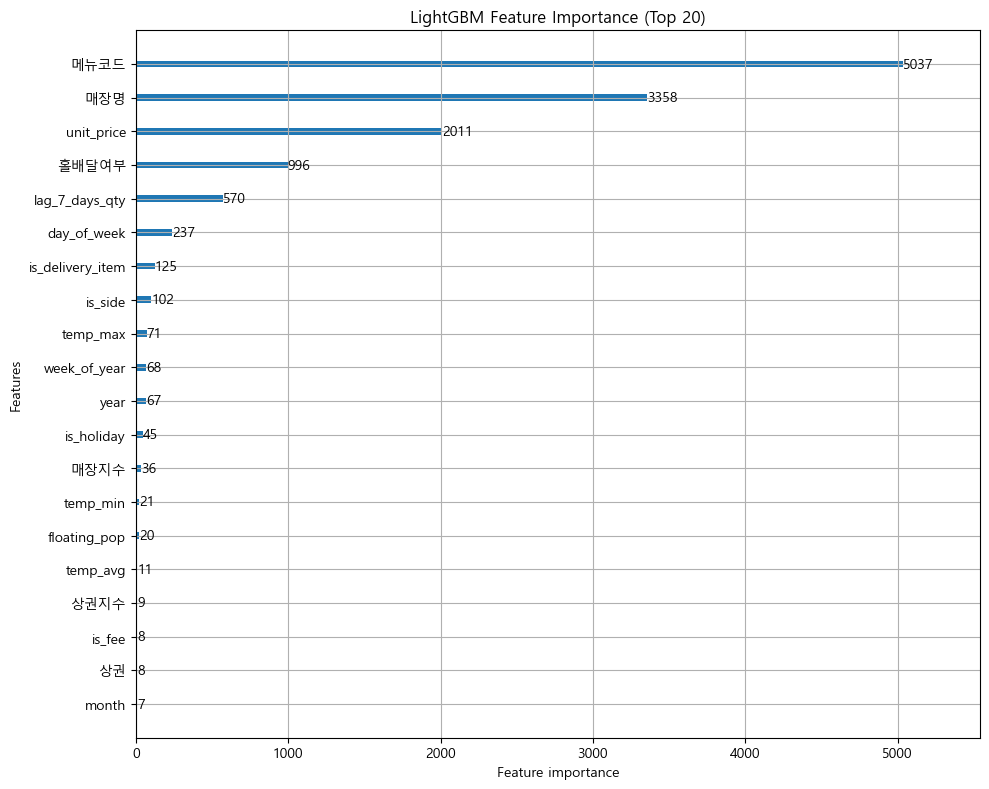

In [ ]:
print("\n--- 7. 모델 평가 및 해석 ---")

# 1. 검증 데이터로 예측 수행
preds = lgb_model.predict(X_val)

# 2. RMSE (Root Mean Squared Error) 계산
#    RMSE: 예측값이 실제값과 평균적으로 얼마나 차이나는지 알려줍니다.
rmse = np.sqrt(mean_squared_error(y_val, preds))
print(f"최종 검증 RMSE: {rmse:.4f}")
print(f"(해석: 모델 예측값이 실제 판매량과 평균적으로 약 ±{rmse:.2f}개 차이납니다.)")

# 3. 피처 중요도(Feature Importance) 시각화 (Top 20)
print("\n피처 중요도 (Top 20):")

# 한글 폰트 설정
plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호 깨짐 방지
if platform.system() == 'Darwin': # 맥OS
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # 윈도우
    path = "c:/Windows/Fonts/malgun.ttf" # 맑은 고딕 경로
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else: # 기타 OS (리눅스 등)
    print('Warning: 한글 폰트를 찾을 수 없습니다. 기본 폰트를 사용합니다.')
    # 필요시 나눔고딕 등 설치 후 경로 지정


lgb.plot_importance(lgb_model, max_num_features=20, figsize=(10, 8))
plt.title("LightGBM Feature Importance (Top 20)")
plt.tight_layout() # 레이블 겹침 방지
plt.show()



In [ ]:

mae = mean_absolute_error(y_val, preds)
print(f"최종 검증 MAE: {mae:.4f}")
print(f"(해석: 모델 예측값이 실제 판매량과 평균적으로 ±{mae:.2f}개 차이납니다.)")

★★ 최종 검증 MAE: 2.6502 ★★
(해석: 모델 예측값이 실제 판매량과 평균적으로 ±2.65개 차이납니다.)


In [ ]:
r2 = r2_score(y_val, preds)
print(f"최종 검증 R²: {r2:.4f}")
print(f"(해석: 모델이 판매량 변동성의 약 {r2*100:.1f}%를 설명합니다.)")

★★ 최종 검증 R²: 0.5862 ★★
(해석: 모델이 판매량 변동성의 약 58.6%를 설명합니다.)


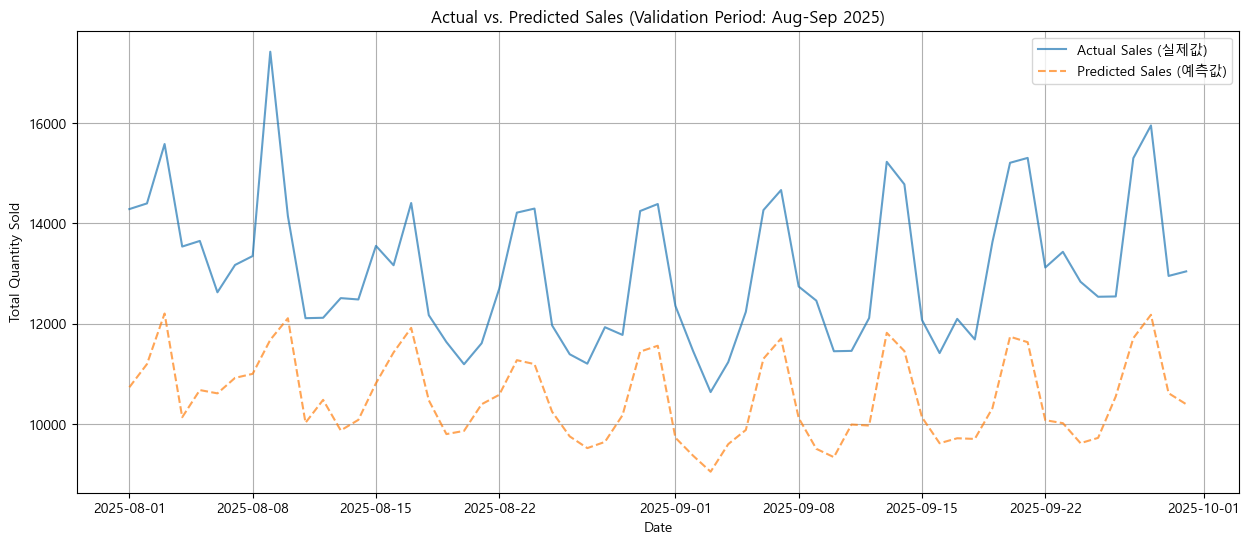

In [34]:
# 검증 데이터(val_df)에 예측값(preds) 컬럼 추가
val_df['predictions'] = preds

# 날짜별 실제 판매량 합계와 예측 판매량 합계 계산
daily_comparison = val_df.groupby('date')[['수량', 'predictions']].sum().reset_index()

# 그래프 그리기
plt.figure(figsize=(15, 6))
plt.plot(daily_comparison['date'], daily_comparison['수량'], label='Actual Sales (실제값)', alpha=0.7)
plt.plot(daily_comparison['date'], daily_comparison['predictions'], label='Predicted Sales (예측값)', linestyle='--', alpha=0.7)
plt.title('Actual vs. Predicted Sales (Validation Period: Aug-Sep 2025)')
plt.xlabel('Date')
plt.ylabel('Total Quantity Sold')
plt.legend()
plt.grid(True)
plt.show()

# 오차계산

In [ ]:
# 오차 계산
# (preds 변수는 6단계 모델 학습 마지막에 생성됨)
# val_df에 예측값과 오차 컬럼 추가
val_df['predictions'] = preds
val_df['error'] = val_df['수량'] - val_df['predictions'] # 실제값 - 예측값

print("오차(error) 컬럼 생성 완료.")
print(val_df[['수량', 'predictions', 'error']].head())

오차(error) 컬럼 생성 완료.
         수량  predictions     error
2247789   2     1.365422  0.634578
2247764   3     1.793882  1.206118
2247767   1     3.735187 -2.735187
2247766   1     0.877841  0.122159
2246947   4     2.063369  1.936631


In [36]:
# 큰 오차 확인하기(과소/과대 예측)
# 과소 예측 (실제 >> 예측): error가 가장 큰 Top 20
print("\n--- 오차가 큰 경우 (과소 예측 Top 20) ---")
print(val_df.sort_values(by='error', ascending=False).head(20)[['date', '매장명', '메뉴명', '수량', 'predictions', 'error']])

# 과대 예측 (실제 << 예측): error가 가장 작은 Top 20
print("\n--- 오차가 큰 경우 (과대 예측 Top 20) ---")
print(val_df.sort_values(by='error', ascending=True).head(20)[['date', '매장명', '메뉴명', '수량', 'predictions', 'error']])


--- 오차가 큰 경우 (과소 예측 Top 20) ---
              date  매장명  메뉴명   수량  predictions       error
2337062 2025-09-06   31  설렁탕  363     5.491081  357.508919
2287797 2025-08-17   31  설렁탕  304    10.409264  293.590736
2389327 2025-09-27   31  설렁탕  282     7.862113  274.137887
2253466 2025-08-03    1  설렁탕  329   108.933777  220.066223
2371963 2025-09-20   31  설렁탕  288    79.642683  208.357317
2284187 2025-08-15   31  설렁탕  212     7.840947  204.159053
2256647 2025-08-04   31  설렁탕  214    10.081153  203.918847
2315046 2025-08-28   31  설렁탕  205     6.483634  198.516366
2323190 2025-08-31    1  설렁탕  204     9.554156  194.445844
2248729 2025-08-01   31  설렁탕  262    68.217379  193.782621
2385001 2025-09-25   31  설렁탕  201    14.258334  186.741666
2324610 2025-08-31   31  설렁탕  308   131.039923  176.960077
2256180 2025-08-04    1  설렁탕  238    70.873348  167.126652
2301302 2025-08-22   31  설렁탕  205    37.935306  167.064694
2373834 2025-09-21   17  설렁탕  175     8.014970  166.985030
2375468 2025-09-21   31

In [37]:
# 그룹별 평균 오차 분석
# 메뉴별 평균 오차 (어떤 메뉴 예측을 어려워하는가?)
menu_error_avg = val_df.groupby('메뉴명')['error'].mean().sort_values(ascending=False)
print("\n--- 메뉴별 평균 오차 (Top 20 과소예측) ---")
print(menu_error_avg.head(20))
print("\n--- 메뉴별 평균 오차 (Top 20 과대예측) ---")
print(menu_error_avg.tail(20))

# 날짜별 평균 오차 (어떤 날 예측을 어려워하는가?)
date_error_avg = val_df.groupby('date')['error'].mean()
print("\n--- 날짜별 평균 오차 ---")
print(date_error_avg.head())

# 요일별 평균 오차 (특정 요일 예측에 편향이 있는가?)
dow_error_avg = val_df.groupby('day_of_week')['error'].mean()
print("\n--- 요일별 평균 오차 (0:월요일 ~ 6:일요일) ---")
print(dow_error_avg)


--- 메뉴별 평균 오차 (Top 20 과소예측) ---
메뉴명
SVC설렁탕육수                    20.190782
맑은소고기무국                     17.297598
[보양] 설렁탕                    15.169763
[시그니처] 설렁탕+수만두 세트           12.176743
소고기미역국                      10.656261
설렁탕+만두세트                     9.420388
설렁탕                          9.304236
행)삼계설렁탕                      8.991173
설렁탕 100% 호주산 왕사골             7.985515
포토 리뷰 이벤트 참여                 7.495338
[육개장] 얼큰설렁탕 해장용 설렁탕          7.027897
설렁탕(포장행사)                    6.994832
배)탕세트1(설렁탕(1인)+갈비만두(5알))     6.741546
후기약속                         6.212761
수저 O                         6.013766
행)수만두설렁탕                     5.806211
[보양]소사골 삼계탕백숙(찹쌀밥들어가요)       5.482058
행)김치만두설렁탕                    5.428798
[육개장] 얼큰설렁탕                  5.342445
수만두1알                        5.317690
Name: error, dtype: float64

--- 메뉴별 평균 오차 (Top 20 과대예측) ---
메뉴명
공기밥 공기밥                     -2.111430
설렁탕(솥밥)                     -2.184068
[한정수량] 설렁탕포장(비조리)           -2.213629
(배달)소주                  

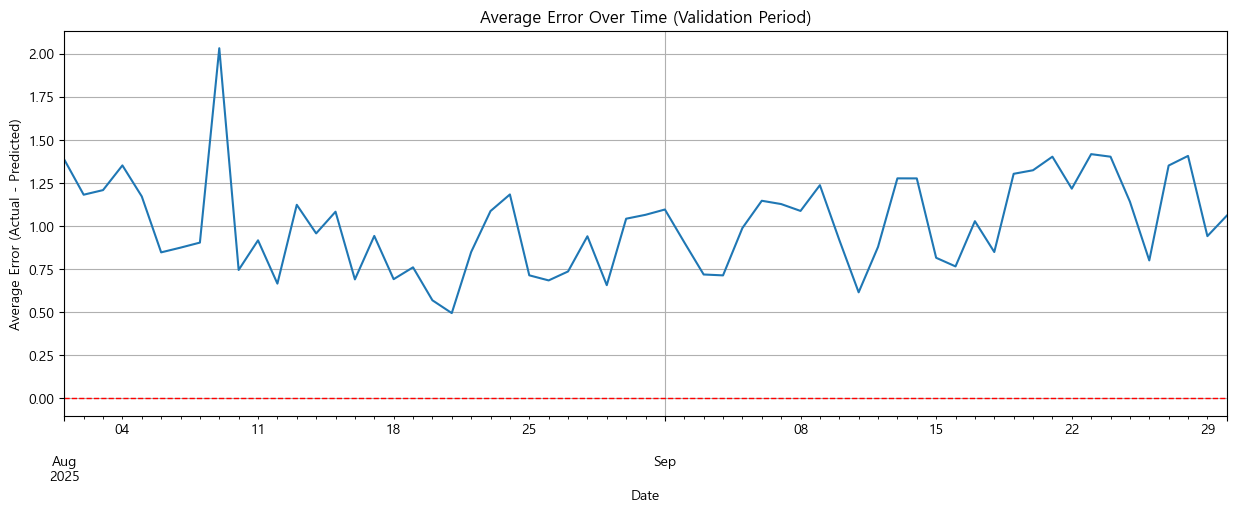

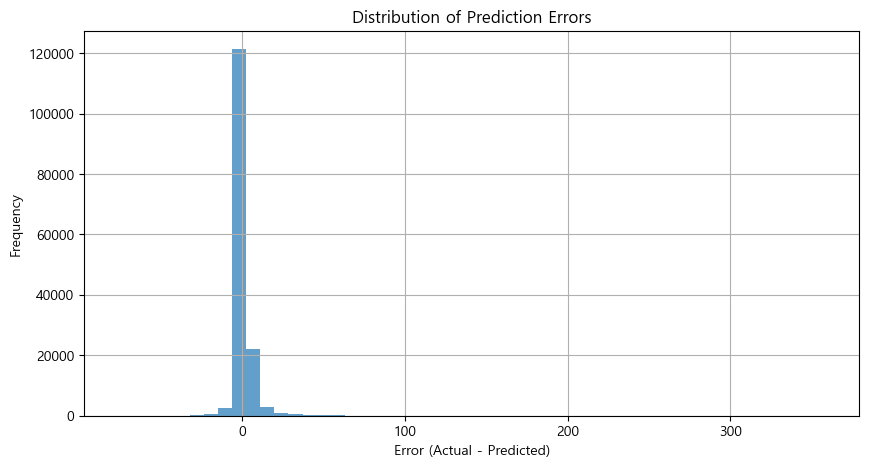

In [38]:
# 날짜별 평균 오차 시계열 그래프
plt.figure(figsize=(15, 5))
date_error_avg.plot()
plt.title('Average Error Over Time (Validation Period)')
plt.xlabel('Date')
plt.ylabel('Average Error (Actual - Predicted)')
plt.axhline(0, color='red', linestyle='--', linewidth=1) # 오차 0 기준선
plt.grid(True)
plt.show()

# 오차 분포 히스토그램
plt.figure(figsize=(10, 5))
plt.hist(val_df['error'], bins=50, alpha=0.7)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

그래프 1: 전체 판매량 시계열 추이 저장 중...


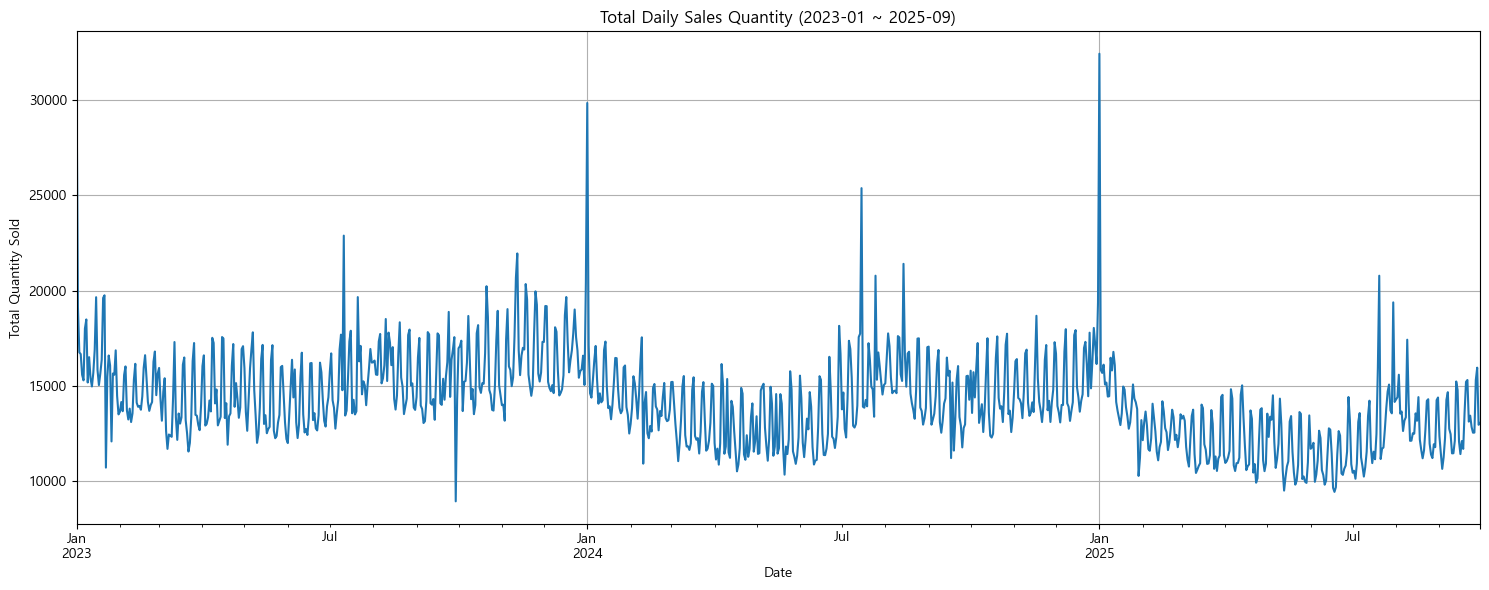

그래프 2: 실제값 vs. 예측값 비교 저장 중...


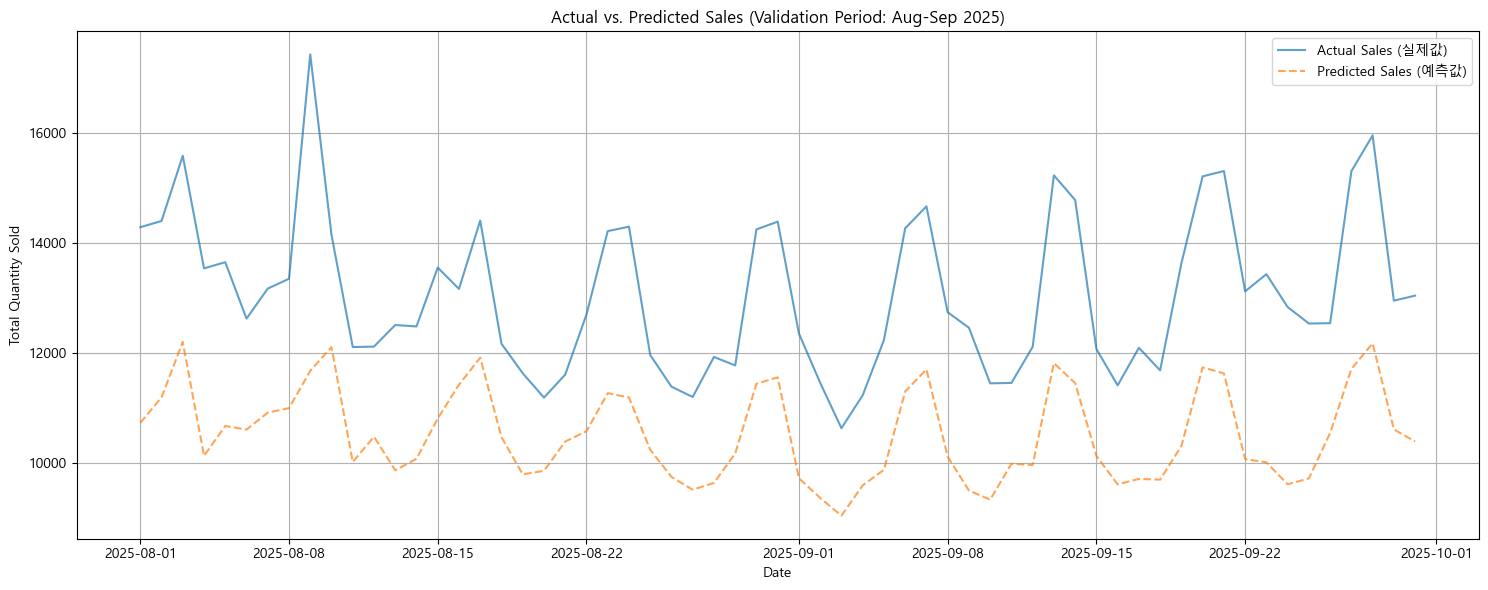

그래프 3: 피처 중요도 저장 중...


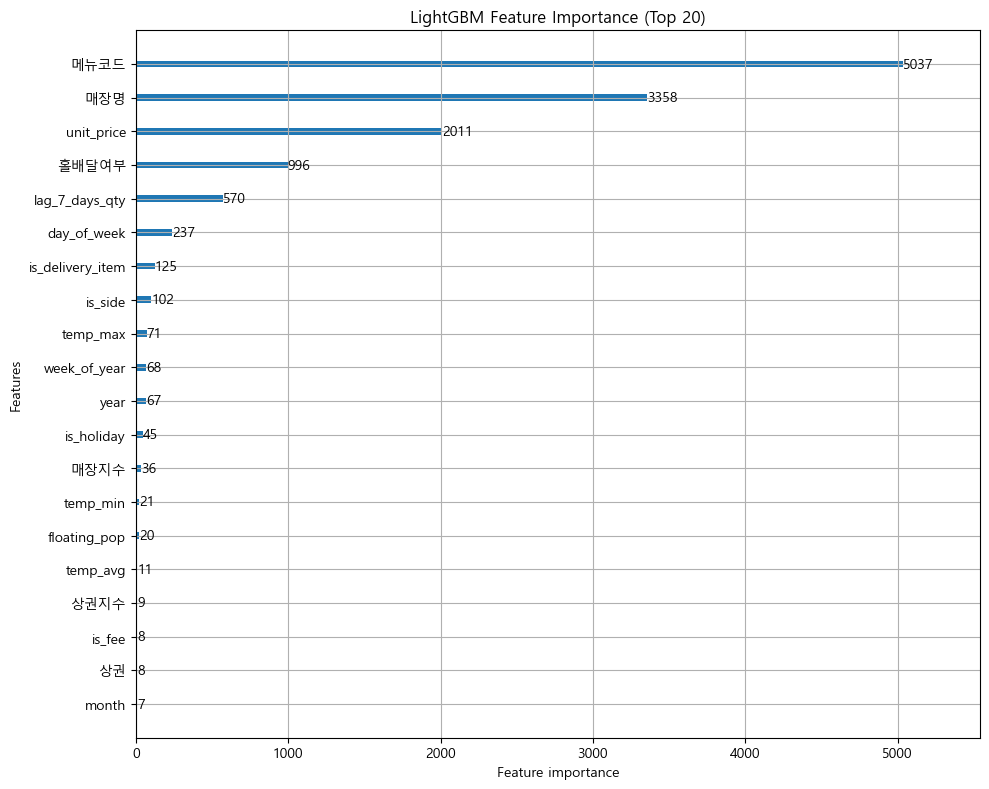


✅ 그래프 3개 저장 완료! 경로: C:\hanchon\reports\images

EDA 그래프 저장 중...
그래프 4: 기온-판매량 관계 저장 중...


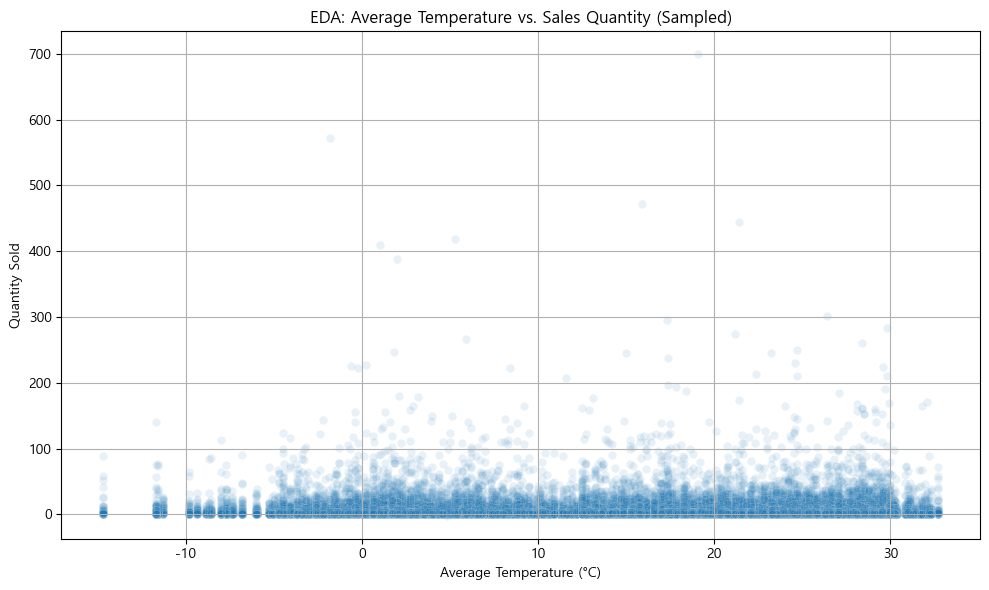

그래프 5: 요일별 평균 판매량 저장 중...


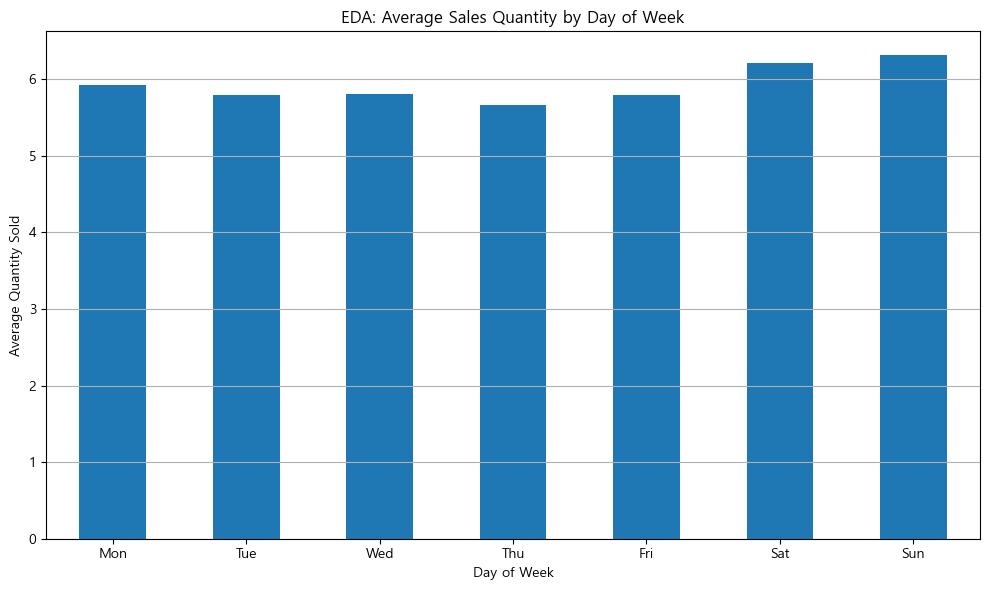


오차 분석 그래프 저장 중...
그래프 6: 날짜별 평균 오차 저장 중...


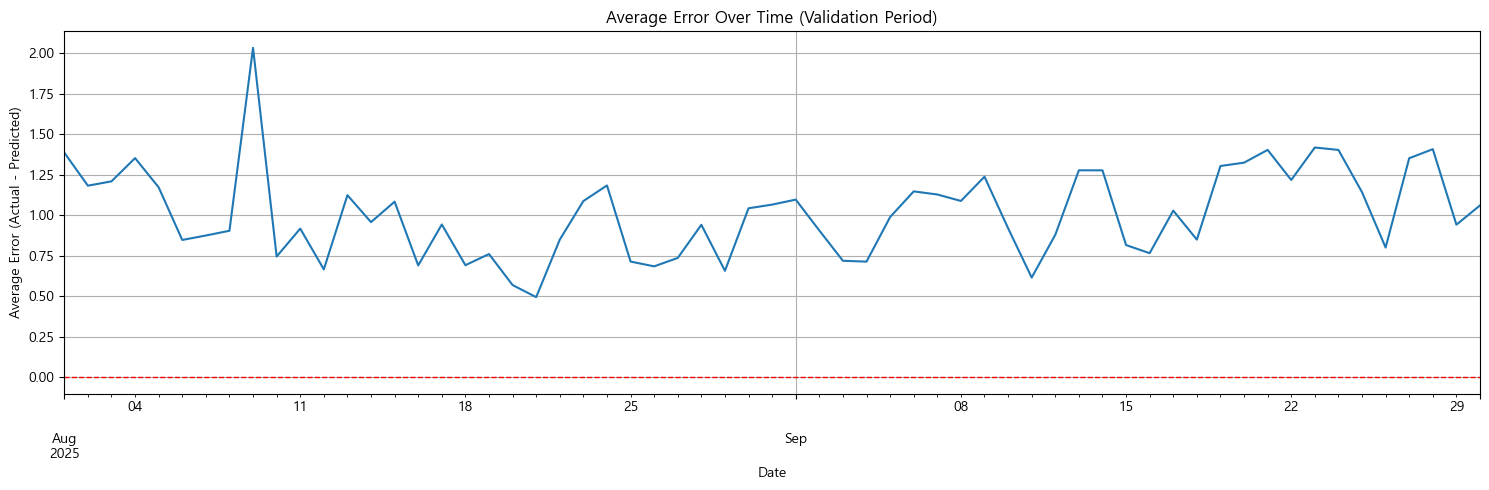

그래프 7: 오차 분포 저장 중...


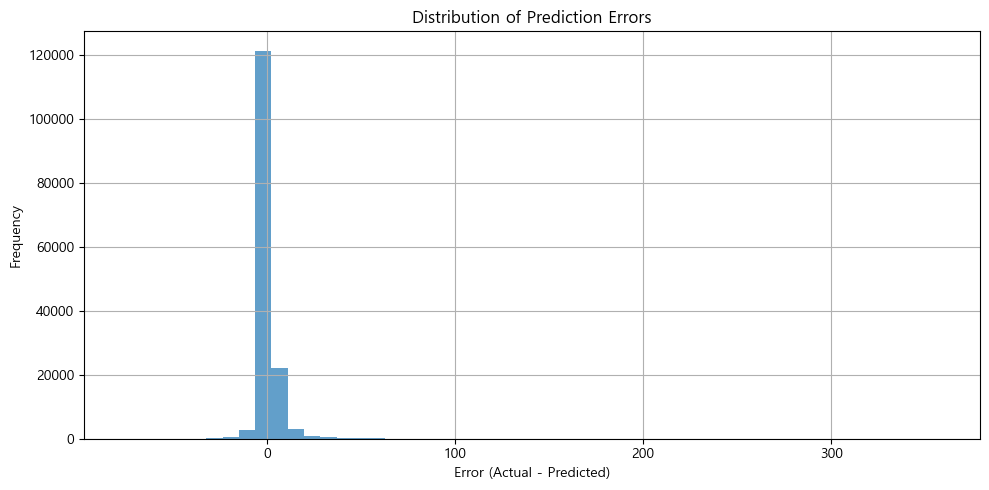


✅ 추가 그래프 4개 저장 완료! 경로: C:\hanchon\reports\images


In [39]:
import matplotlib.pyplot as plt
import seaborn as sns # Plotting library
import os

# --- 그래프 저장 경로 설정 ---
output_image_dir = r'C:\hanchon\reports\images'
os.makedirs(output_image_dir, exist_ok=True) # 폴더 없으면 생성

# ---------------------------------------------
# 그래프 1: 전체 판매량 시계열 추이
# (final_dataset이 메모리에 없다면 다시 로드)
final_dataset = pd.read_csv(r'C:\hanchon\data\processed\final_integrated_dataset.csv')
final_dataset['date'] = pd.to_datetime(final_dataset['date'])
# ---------------------------------------------
print("그래프 1: 전체 판매량 시계열 추이 저장 중...")
daily_total_sales = final_dataset.groupby('date')['수량'].sum()

plt.figure(figsize=(15, 6))
daily_total_sales.plot()
plt.title('Total Daily Sales Quantity (2023-01 ~ 2025-09)')
plt.xlabel('Date')
plt.ylabel('Total Quantity Sold')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_image_dir, '01_total_sales_trend.png'))
plt.show() # 노트북에서 바로 보려면 주석 해제

# ---------------------------------------------
# 그래프 2: 실제값 vs. 예측값 비교 (검증 기간)
# (val_df와 preds 변수가 메모리에 있어야 함)
# ---------------------------------------------
print("그래프 2: 실제값 vs. 예측값 비교 저장 중...")
# 날짜별 실제 판매량 합계와 예측 판매량 합계 계산 (val_df 사용)
if 'predictions' not in val_df.columns: # preds가 val_df에 없으면 추가
    val_df['predictions'] = preds
daily_comparison = val_df.groupby('date')[['수량', 'predictions']].sum().reset_index()

plt.figure(figsize=(15, 6))
plt.plot(daily_comparison['date'], daily_comparison['수량'], label='Actual Sales (실제값)', alpha=0.7)
plt.plot(daily_comparison['date'], daily_comparison['predictions'], label='Predicted Sales (예측값)', linestyle='--', alpha=0.7)
plt.title('Actual vs. Predicted Sales (Validation Period: Aug-Sep 2025)')
plt.xlabel('Date')
plt.ylabel('Total Quantity Sold')
# ★★ 한글 폰트 설정 시작 (그래프 깨짐 방지) ★★
import platform
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False
if platform.system() == 'Darwin': rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"; font_name = font_manager.FontProperties(fname=path).get_name(); rc('font', family=font_name)
else: print('Warning: 한글 폰트를 찾을 수 없습니다.')
# ★★ 한글 폰트 설정 끝 ★★
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_image_dir, '02_actual_vs_predicted.png'))
plt.show()

# ---------------------------------------------
# 그래프 3: 피처 중요도 (Top 20)
# (lgb_model 변수가 메모리에 있어야 함)
# ---------------------------------------------
print("그래프 3: 피처 중요도 저장 중...")
fig, ax = plt.subplots(figsize=(10, 8)) # 그래프 객체 생성
lgb.plot_importance(lgb_model, max_num_features=20, ax=ax)
plt.title("LightGBM Feature Importance (Top 20)")
# ★★ 한글 폰트 설정은 위에서 이미 완료됨 ★★
plt.tight_layout()
plt.savefig(os.path.join(output_image_dir, '03_feature_importance.png'))
plt.show()

print(f"\n✅ 그래프 3개 저장 완료! 경로: {output_image_dir}")


# --- EDA 그래프 저장 ---
print("\nEDA 그래프 저장 중...")

# --- 그래프 4: EDA - 기온과 판매량 관계 (Scatter Plot 예시) ---
# (샘플링하여 그리는 것이 효율적일 수 있음)
print("그래프 4: 기온-판매량 관계 저장 중...")
eda_sample = final_dataset.sample(n=50000, random_state=42) # 5만개 샘플링

plt.figure(figsize=(10, 6))
sns.scatterplot(data=eda_sample, x='temp_avg', y='수량', alpha=0.1) # alpha로 점 투명도 조절
plt.title('EDA: Average Temperature vs. Sales Quantity (Sampled)')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Quantity Sold')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_image_dir, '04_eda_temp_vs_quantity.png'))
plt.show()

# --- 그래프 5: EDA - 요일별 평균 판매량 (Bar Plot 예시) ---
print("그래프 5: 요일별 평균 판매량 저장 중...")
# day_of_week가 없다면 생성 (final_dataset에 있어야 함)
if 'day_of_week' not in final_dataset.columns:
    final_dataset['day_of_week'] = final_dataset['date'].dt.dayofweek

daily_avg_sales = final_dataset.groupby('day_of_week')['수량'].mean()
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'] # 요일 이름 매핑

plt.figure(figsize=(10, 6))
daily_avg_sales.plot(kind='bar')
plt.title('EDA: Average Sales Quantity by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Quantity Sold')
plt.xticks(ticks=range(7), labels=day_names, rotation=0) # x축 레이블 변경
plt.grid(axis='y') # y축 그리드만 표시
plt.tight_layout()
plt.savefig(os.path.join(output_image_dir, '05_eda_avg_sales_by_dow.png'))
plt.show()

# --- 오차 분석 그래프 저장 ---
print("\n오차 분석 그래프 저장 중...")

# --- 그래프 6: 날짜별 평균 오차 (Line Plot) ---
# (val_df와 date_error_avg 변수가 메모리에 있어야 함)
print("그래프 6: 날짜별 평균 오차 저장 중...")
if 'error' not in val_df.columns: # error 컬럼 생성 확인
     val_df['predictions'] = preds # preds가 필요
     val_df['error'] = val_df['수량'] - val_df['predictions']
date_error_avg = val_df.groupby('date')['error'].mean() # date_error_avg 재생성

plt.figure(figsize=(15, 5))
date_error_avg.plot()
plt.title('Average Error Over Time (Validation Period)')
plt.xlabel('Date')
plt.ylabel('Average Error (Actual - Predicted)')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_image_dir, '06_error_trend_over_time.png'))
plt.show()

# --- 그래프 7: 오차 분포 (Histogram) ---
print("그래프 7: 오차 분포 저장 중...")
plt.figure(figsize=(10, 5))
plt.hist(val_df['error'], bins=50, alpha=0.7) # bins 개수 조절 가능
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_image_dir, '07_error_distribution.png'))
plt.show()

print(f"\n✅ 추가 그래프 4개 저장 완료! 경로: {output_image_dir}")